# Page Rank
PageRank is widely recognized as a way of detecting influential nodes in a graph.
It is different to other centrality algorithms because the influence of a node depends on the influence of its neighbours.

The underlying mathematics of PageRank is based on random walks on networks.
We can think of a random walk as the way that a person might manually traverse a graph.
We start from any node and then either follow one of its relationships to another node or jump to another node in the graph and continue our exploration.
The PageRank of a node is the probability that it is visited during this random walk.
More influential nodes will be visited more often.

First we'll import the Neo4j driver and Pandas libraries:


In [482]:
from neo4j.v1 import GraphDatabase, basic_auth
import pandas as pd
import os

Next let's create an instance of the Neo4j driver which we'll use to execute our queries.


In [483]:
host = os.environ.get("NEO4J_HOST", "bolt://localhost") 
user = os.environ.get("NEO4J_USER", "neo4j")
password = os.environ.get("NEO4J_PASSWORD", "neo")
driver = GraphDatabase.driver(host, auth=basic_auth(user, password))

Now let's create a sample graph that we'll run the algorithm against.


In [484]:
create_graph_query = '''
MERGE (home:Page {name:'Home'})
MERGE (about:Page {name:'About'})
MERGE (product:Page {name:'Product'})
MERGE (links:Page {name:'Links'})
MERGE (a:Page {name:'Site A'})
MERGE (b:Page {name:'Site B'})
MERGE (c:Page {name:'Site C'})
MERGE (d:Page {name:'Site D'})

MERGE (home)-[:LINKS]->(about)
MERGE (about)-[:LINKS]->(home)
MERGE (product)-[:LINKS]->(home)
MERGE (home)-[:LINKS]->(product)
MERGE (links)-[:LINKS]->(home)
MERGE (home)-[:LINKS]->(links)
MERGE (links)-[:LINKS]->(a)
MERGE (a)-[:LINKS]->(home)
MERGE (links)-[:LINKS]->(b)
MERGE (b)-[:LINKS]->(home)
MERGE (links)-[:LINKS]->(c)
MERGE (c)-[:LINKS]->(home)
MERGE (links)-[:LINKS]->(d)
MERGE (d)-[:LINKS]->(home)
'''

with driver.session() as session:
    result = session.write_transaction(lambda tx: tx.run(create_graph_query))
    print("Stats: " + str(result.consume().metadata.get("stats", {})))

Stats: {}


Finally we can run the algorithm by executing the following query:


In [485]:
streaming_query = """
CALL algo.pageRank.stream('Page', 'LINKS', {iterations:20, dampingFactor:0.85})
YIELD node, score
RETURN node.name AS page,score
ORDER BY score DESC
"""

with driver.session() as session:
    result = session.read_transaction(lambda tx: tx.run(streaming_query))        
    df = pd.DataFrame([r.values() for r in result], columns=result.keys())

df

,page,score
0,Home,3.233877
1,About,1.060435
2,Product,1.060435
3,Links,1.060435
4,Site A,0.329035
5,Site B,0.329035
6,Site C,0.329035
7,Site D,0.329035


As we might expect, the Home page has the highest PageRank because it has incoming links from all other pages.
We can also see that it's not only the number of incoming links that is important, but also the importance of the pages behind those links.

In [486]:
from IPython.core.display import display, HTML
from string import Template
import json

query = "MATCH (p1:Page)-[r:LINKS]->(p2:Page) RETURN *"
labels_json = {'Page': {'caption': 'name', 'size': 'pagerank'}}
relationships_json = {'LINKS': {'thickness': 'weight', 'caption': False}}

json_graph = {
    "query": query,
    "labels": labels_json,
    "relationships": relationships_json,
    "host": host,
    "user": user,
    "password": password
}

Javascript("""window.jsonGraph={};""".format(json.dumps(json_graph)))

<IPython.core.display.Javascript object>

In [487]:
%%html
<style type="text/css">                
.output_wrapper, .output {
    height:auto !important;
    max-height:600px;
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}

#vizme {
    width: 300px;
    height: 350px;
    font: 22pt arial;
}
</style>  
<div id="vizme"></div>

In [488]:
%%javascript
requirejs(['neovis.js'], function(NeoVis){    
    var config = {
      container_id: "vizme",
      server_url: window.jsonGraph.host,
      server_user: window.jsonGraph.user,
      server_password: window.jsonGraph.password,
      labels: window.jsonGraph.labels,
      relationships: window.jsonGraph.relationships,
      initial_cypher: window.jsonGraph.query
    };
        
    let viz = new NeoVis.default(config);
    viz.render();
    
    viz.onVisualizationRendered(function(ctx) {
      let imageSrc = ctx.canvas.toDataURL();
      let kernel = IPython.notebook.kernel;
      let command = "image_src = '" + imageSrc + "'";
      kernel.execute(command);

    });
});

<IPython.core.display.Javascript object>


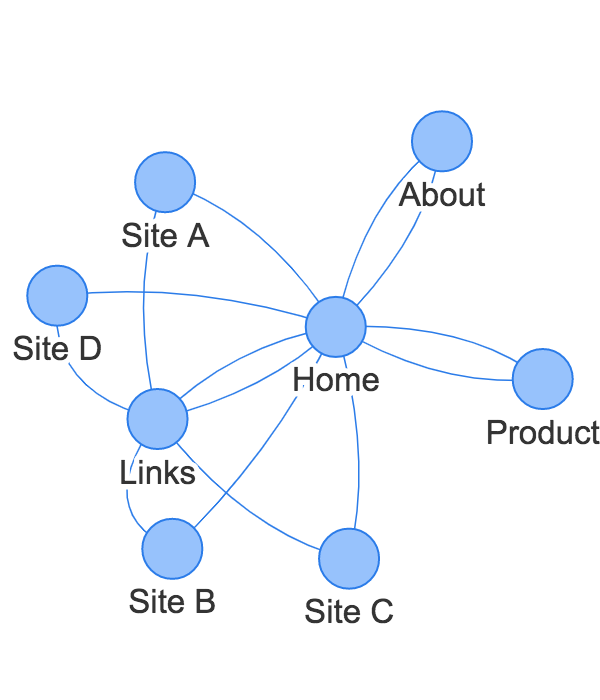

In [489]:
display(HTML('<img id=\"viz-image\" width=\"300px\" src="%s" />' % image_src))